In [2]:
pip install pyAudioAnalysis

Note: you may need to restart the kernel to use updated packages.


In [1]:
import os, glob
import pandas as pd
import numpy as np
from collections import defaultdict
import wave, struct
import matplotlib.pyplot as plt
import pyAudioAnalysis.ShortTermFeatures as sF
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneGroupOut
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from joblib import dump, load
from scipy.signal import find_peaks

In [2]:
#Flags
use_delta = False
fWindowSize = 0.02
fStepSize = 0.01
Context = (-2,-1,0,1,2)
working_dir = 'BeepDetModel/'
egs_dir = os.path.join(working_dir,'egs_44')
nFeatures = 68 if use_delta else 34

## Feature Extraction

In [8]:
#Load CSV file in dictionary of key=filename, value=[(start_beep_time,end_beep_time),]
dBeepTimes = defaultdict(list)
sBeepTimesCSVFile = 'Beep_Times.csv'
Beep_Times = pd.read_csv(sBeepTimesCSVFile,header=None)
for index, row in Beep_Times.iterrows():
    sWavFile = row[0]
    i = 1
    while i <= row.size-1:
        #print(i)
        if not np.isnan(row[i]):
            dBeepTimes[sWavFile].append((row[i],row[i+1]))
            i += 2
        else:
            i += 1

In [13]:
#Load each wav file, split to frames and extract features
testFileNames = ['/media/Windows/root/AusKidTalk/Recordings/28_jul_2020/81 3_2_0/81 Primary_13-01.wav']
#working_dir = 'egs/BeepDetModel'
#egs_dir = os.path.join(working_dir,'egs')

os.makedirs(egs_dir)

use_delta = False
fWindowSize = 0.02
fStepSize = 0.01
Context = (-2,-1,0,1,2)

nFeatures = 68 if use_delta else 34

nNonBeepSamples = 3000

#data_beep = np.zeros((1000000,len(Context)*nFeatures+1),dtype=float) #Num Features + 1 for file index 
#data_NonBeep = np.zeros((1000000,len(Context)*nFeatures+1),dtype=float)


alldata = []
nNonBeepPerFile = int(nNonBeepSamples/len(dBeepTimes))
FileIndx = 0

#Get number of padded rows for context
nPostPad = max(Context)
nPrePad = abs(min(Context))

for sWavFile in dBeepTimes:
    data_beep = np.zeros((1000000,len(Context)*nFeatures+1),dtype=float) #Num Features + 1 for file index and (1 or 0) for beep and nonbeep samples 
    data_NonBeep = np.zeros((1000000,len(Context)*nFeatures+1),dtype=float)
    iBeepPointer = 0
    iNonBeepPointer = 0

    #if WavFile in testFileNames:
    #   continue
    iCurrSample = 0
    with wave.open(sWavFile) as fWav:
        #Make sure that the sampling size is 16 bit
        assert fWav.getsampwidth() == 2, 'Only 16 bit resolution supported'
        
        iFrameRate = fWav.getframerate()
        nTotalFrames = fWav.getnframes()
        lNonBeepFramesIndxs = []
        
        #Read beep samples
        for fStartTime, fEndTime in dBeepTimes[sWavFile]:
            iStartFram = int(fStartTime * iFrameRate)
            iEndFram = int(fEndTime * iFrameRate)
            
            if iCurrSample <= iStartFram-2*iFrameRate:
                lNonBeepFramesIndxs.append((iCurrSample,iStartFram-iFrameRate))#Get all non Beep samples we leave 1 second before the start of beep
                iCurrSample = iEndFram + iFrameRate
            
            nFrames = iEndFram - iStartFram
            fWav.setpos(iStartFram)
            
            data = fWav.readframes(nFrames)
            data = [ i[0] for i in struct.iter_unpack('h',data)]
            data = np.asarray(data)
            
            aFeatures, lFeatures_names = sF.feature_extraction(data,iFrameRate,int(fWindowSize*iFrameRate),int(fStepSize*iFrameRate),deltas=use_delta)
            
            aFeatures = aFeatures.T
            #Handle context
            aPostPad = np.zeros((nPostPad,aFeatures.shape[1]))
            aPrePad = np.zeros((nPrePad,aFeatures.shape[1]))
            
            aFeatures_pad = np.r_[aPrePad,aFeatures,aPostPad]
            
            aShiftVer = [np.roll(aFeatures_pad, i, axis=0) for i in Context[::-1]]
            
            aFeatures_beep = np.concatenate(aShiftVer,axis=1)[0+nPrePad:-nPostPad]
            aFeatures_beep = np.c_[aFeatures_beep,np.zeros(aFeatures_beep.shape[0])+FileIndx]
                        
            data_beep[iBeepPointer:iBeepPointer+aFeatures_beep.shape[0]] = aFeatures_beep
            
            iBeepPointer += aFeatures_beep.shape[0]
            print("Processing {0} from fram {1} to {2} samples {3}".format(sWavFile,iStartFram,iEndFram,aFeatures_beep.shape))
        
        #Get Random non-beep samples
        nNonBeepSegments = len(lNonBeepFramesIndxs)
        nNonBeepPerSegment = int(nNonBeepPerFile/nNonBeepSegments)
        lSamples = []
        for iStart, iEnd in lNonBeepFramesIndxs:
            lSamples.extend(np.random.choice(range(iStart,iEnd),nNonBeepPerSegment,replace=False))
        print("{0} NonBeep random samples selected".format(len(lSamples)))
        i = 0
        for iSample in lSamples:
            i += 1
            #print("{0}/{1}".format(i,len(lSamples)))
            fWav.setpos(iSample)
            
            data = fWav.readframes(int(0.5*iFrameRate))
            data = [ i[0] for i in struct.iter_unpack('h',data)]
            data = np.asarray(data)
            
            aFeatures, lFeatures_names = sF.feature_extraction(data,iFrameRate,int(fWindowSize*iFrameRate),int(fStepSize*iFrameRate),deltas=use_delta)
            
            aFeatures = aFeatures.T
            #Handle context
            aPostPad = np.zeros((nPostPad,aFeatures.shape[1]))
            aPrePad = np.zeros((nPrePad,aFeatures.shape[1]))
            
            aFeatures_pad = np.r_[aPrePad,aFeatures,aPostPad]
            
            aShiftVer = [np.roll(aFeatures_pad, i, axis=0) for i in Context[::-1]]
            
            aFeatures_NonBeep = np.concatenate(aShiftVer,axis=1)[0+nPrePad:-nPostPad]
            aFeatures_NonBeep = np.c_[aFeatures_NonBeep,np.zeros(aFeatures_NonBeep.shape[0])+FileIndx]
            
            data_NonBeep[iNonBeepPointer:iNonBeepPointer+aFeatures_NonBeep.shape[0]] = aFeatures_NonBeep
            
            iNonBeepPointer += aFeatures_NonBeep.shape[0]
    data_beep = data_beep[:iBeepPointer]
    data_NonBeep = data_NonBeep[:iNonBeepPointer]
    data_beep = np.c_[data_beep,np.ones(data_beep.shape[0],dtype=int)]
    data_NonBeep = np.c_[data_NonBeep,np.zeros(data_NonBeep.shape[0],dtype=int)]
    data = np.r_[data_beep, data_NonBeep]

    print("File {2}, Total Number of Beep Samples {0}, Total Number of NonBeep Samples {1}".format(data_beep.shape[0],data_NonBeep.shape[0],sWavFile))
    np.save(os.path.join(egs_dir,'egs_{1}_{0}'.format(FileIndx,len(Context))),data)
          
    FileIndx += 1
    
#data_beep = data_beep[:iBeepPointer]
#data_NonBeep = data_NonBeep[:iNonBeepPointer]
#Add label column


Processing recordings_16/rec2.wav from fram 209600 to 225600 samples (99, 171)
375 NonBeep random samples selected
File recordings_16/rec2.wav, Total Number of Beep Samples 99, Total Number of NonBeep Samples 18375
Processing recordings_16/rec3.wav from fram 558560 to 574560 samples (99, 171)
Processing recordings_16/rec3.wav from fram 3110960 to 3126960 samples (99, 171)
Processing recordings_16/rec3.wav from fram 5317088 to 5333088 samples (99, 171)
Processing recordings_16/rec3.wav from fram 16808608 to 16824608 samples (99, 171)
Processing recordings_16/rec3.wav from fram 17048496 to 17064496 samples (99, 171)
Processing recordings_16/rec3.wav from fram 20288512 to 20304512 samples (99, 171)
Processing recordings_16/rec3.wav from fram 21723744 to 21739744 samples (99, 171)
Processing recordings_16/rec3.wav from fram 22260640 to 22276640 samples (99, 171)
Processing recordings_16/rec3.wav from fram 22762144 to 22778144 samples (99, 171)
369 NonBeep random samples selected
File recor

In [14]:
#egs = np.load('BeepDetModel/egs/egs_5_0.npy')

In [23]:
#egs[:,-1]

array([1., 1., 1., ..., 0., 0., 0.])

In [25]:
#aFeatures, lFeatures_names = sF.feature_extraction(data,iFrameRate,int(fWindowSize*iFrameRate),int(fStepSize*iFrameRate),deltas=use_delta)

ValueError: cannot reshape array of size 55040 into shape (32,10)

## Analyze Features

In [26]:
#Get egs data
legs = glob.glob(os.path.join(egs_dir,'*.npy'))
assert len(legs) > 0, 'No egs'

#Load data from egs directory
data = np.concatenate([np.load(file) for file in legs],axis=0)

#Put features without context in DataFram
left_context = abs(min(Context))
right_context = max(Context)
data_NoContxt = np.c_[data[:,left_context*nFeatures:(left_context+1)*nFeatures], data[:,-2:]]
pdData = pd.DataFrame(data=data_NoContxt,columns=lFeatures_names+['FileIndx','label'])

<AxesSubplot:xlabel='zcr', ylabel='spectral_rolloff'>

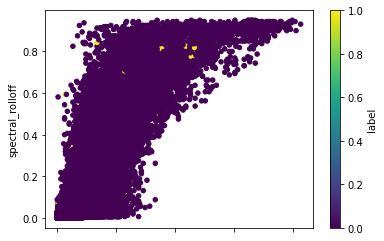

In [27]:
#Plot Data
pdData = pdData.astype({'label':int,'FileIndx':int})
pdData.plot.scatter(lFeatures_names[0],lFeatures_names[7],c='label',colormap='viridis')

## Building Classification Model

In [4]:
#Data Selection
#egs_dir='/media/Windows/root/AusKidTalk/Initiate_Aligner/AusKidTalk/egs/BeepDetModel_19-8/egs'
#Load data from numpy pickle
#Get egs data
legs = glob.glob(os.path.join(egs_dir,'*.npy'))
assert len(legs) > 0, 'No egs'

#Load data from egs directory
data = np.concatenate([np.load(file) for file in legs],axis=0)
X = data[:,:-2]
y = data[:,-1].astype(int)
groups = data[:,-2].astype(int)

#Split data where one recording out
spliter = LeaveOneGroupOut()
print(spliter.get_n_splits(X,y,groups))
print(X.shape,y.shape)


#Start with random split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)

8
(149830, 170) (149830,)


In [6]:
#Data Normalizatio
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [ ]:
#Train SVM model simple Linear model
#clf = svm.SVC(kernel='rbf',C=10, gamma=1e-3, class_weight='balanced')
clf = svm.SVC(kernel='linear',C=1.0, gamma=1e-3, class_weight='balanced',verbose=2)
clf.fit(X_train_std,y_train)
y_pred = clf.predict(X_test_std)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

[LibSVM].........................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
#Split where one recording for test and others for training
iSplit=0
for train_index, test_index in spliter.split(X,y,groups):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    print('********Split {0} with {1} training examples and {2} testing examples'.format(iSplit,y_train.shape[0],y_test.shape[0]))
    #Data Normalizatio
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_test_std = scaler.transform(X_test)
    #Train SVM model 
    clf = svm.SVC(kernel='rbf',C=100, gamma=1e-3, class_weight='balanced')
    clf.fit(X_train_std,y_train)
    y_pred = clf.predict(X_test_std)
    print('**************Results of split ',iSplit)
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    iSplit += 1

********Split 0 with 131356 training examples and 18474 testing examples
**************Results of split  0
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     18375
           1       0.00      0.05      0.00        99

    accuracy                           0.89     18474
   macro avg       0.50      0.47      0.47     18474
weighted avg       0.99      0.89      0.94     18474

[[16420  1955]
 [   94     5]]
********Split 1 with 130858 training examples and 18972 testing examples


In [4]:
#Split where one recording for test and others for training
iSplit=0
for train_index, test_index in spliter.split(X,y,groups):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    print('********Split {0} with {1} training examples and {2} testing examples'.format(iSplit,y_train.shape[0],y_test.shape[0]))
    #Data Normalizatio
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_test_std = scaler.transform(X_test)
    #Train SVM model 
    clf = svm.SVC(kernel='rbf',C=100, gamma=1e-3, class_weight='balanced')
    clf.fit(X_train_std,y_train)
    y_pred = clf.predict(X_test_std)
    print('**************Results of split ',iSplit)
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))
    iSplit += 1

********Split 0 with 131266 training examples and 18474 testing examples
**************Results of split  0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18375
           1       0.87      0.96      0.91        99

    accuracy                           1.00     18474
   macro avg       0.94      0.98      0.96     18474
weighted avg       1.00      1.00      1.00     18474

[[18361    14]
 [    4    95]]
********Split 1 with 130758 training examples and 18982 testing examples
**************Results of split  1
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     18081
           1       0.93      0.79      0.86       901

    accuracy                           0.99     18982
   macro avg       0.96      0.90      0.92     18982
weighted avg       0.99      0.99      0.99     18982

[[18026    55]
 [  185   716]]
********Split 2 with 131068 training examples and 18672 testing exampl

In [6]:
#Parameter Tuning CV with Pipeline
pipeLine = Pipeline([('scaler',StandardScaler()),('svc',svm.SVC(class_weight='balanced'))])
tuned_parameters = [{'svc__kernel': ['rbf'], 'svc__gamma': [1e-3, 1e-4],
                     'svc__C': [1, 10, 100, 1000]}]
score = 'recall'
print("# Tuning hyper-parameters for {0}\n".format(score))

cv = spliter.split(X,y,groups)

clf = GridSearchCV(pipeLine, param_grid=tuned_parameters, 
                   scoring="{0}_macro".format(score), n_jobs=3, verbose=5, cv=cv)

clf.fit(X, y)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
#print()
#print("Detailed classification report:")
#print()
#print("The model is trained on the full development set.")
#print("The scores are computed on the full evaluation set.")
#print()
#y_true, y_pred = y_test, clf.predict(X)
#print(classification_report(y_true, y_pred))
#print()

# Tuning hyper-parameters for recall

Fitting 8 folds for each of 8 candidates, totalling 64 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 63.6min
/home/mostafa/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done  64 out of  64 | elapsed: 260.0min finished


Best parameters set found on development set:

{'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}

Grid scores on development set:

0.971 (+/-0.059) for {'svc__C': 1, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.964 (+/-0.064) for {'svc__C': 1, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
0.964 (+/-0.059) for {'svc__C': 10, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.971 (+/-0.057) for {'svc__C': 10, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
0.951 (+/-0.053) for {'svc__C': 100, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.969 (+/-0.053) for {'svc__C': 100, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}
0.951 (+/-0.052) for {'svc__C': 1000, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
0.962 (+/-0.052) for {'svc__C': 1000, 'svc__gamma': 0.0001, 'svc__kernel': 'rbf'}


In [ ]:
#Parameter Tuning (random CV splitting, no pipeline)
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10]}]
score = 'recall'
print("# Tuning hyper-parameters for {0}\n".format(score))

clf = GridSearchCV(svm.SVC(class_weight='balanced'), param_grid=tuned_parameters, 
                   scoring="{0}_macro".format(score), n_jobs=3, verbose=5)

clf.fit(X_train_std, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()
print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, clf.predict(X_test_std)
print(classification_report(y_true, y_pred))
print()

## Build Model With Best Param

In [ ]:
#Use Pipeline
#Best param kernel 'rbf', gamma = 0.001, C = 1000
#Get Training data
TestFileIndex = 1
lFileNames = list(dBeepTimes.keys())
lSplits = list(spliter.split(X,y,groups))
X_train, X_test, y_train, y_test = X[lSplits[TestFileIndex][0]], X[lSplits[TestFileIndex][1]], y[lSplits[TestFileIndex][0]], y[lSplits[TestFileIndex][1]]
print('Train Model with {0} training examples and {1} test examples'.format(X_train.shape[0], X_test.shape[0]))

#scaler = StandardScaler()
#scaler.fit(X)
#X_train_std = scaler.transform(X_train)
#X_test_std = scaler.transform(X_test)

#Train the model
clf = Pipeline([('scaler',StandardScaler()),('svc',svm.SVC(kernel='rbf', C=10, gamma=0.0001, class_weight='balanced'))])
clf.fit(X_train, y_train)

dump(clf, 'Model_{0}.jbl'.format(TestFileIndex))

#Test the model
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print(confusion_matrix(y_true,y_pred))

## Test Beep Time Detection

In [48]:
#Load CSV file in dictionary of key=filename, value=[(start_beep_time,end_beep_time),]
dBeepTimes = defaultdict(list)
sBeepTimesCSVFile = '../../Recordings/Beep_Times.csv'
Beep_Times = pd.read_csv(sBeepTimesCSVFile,header=None)
for index, row in Beep_Times.iterrows():
    sWavFile = row[0]
    i = 1
    while i <= row.size-1:
        #print(i)
        if not np.isnan(row[i]):
            dBeepTimes[sWavFile].append((row[i],row[i+1]))
            i += 2
        else:
            i += 1

In [ ]:
nChunkSize = 1000 #Number of frames to read each time

testFileName = lFileNames[TestFileIndex] #'/media/Windows/root/AusKidTalk/Recordings/13_aug_2020/90 3_2_0/90 Primary_15-01.wav'#'/media/Windows/root/AusKidTalk/Recordings/28_jul_2020/81 3_2_0/81 Primary_13-01.wav'

#Get number of padded rows for context
nPostPad = max(Context)
nPrePad = abs(min(Context))

with wave.open(testFileName) as fWav:
    iFrameRate = fWav.getframerate()
    nSamples = fWav.getnframes()
    assert fWav.getsampwidth() == 2, 'Only 16 bit resolution supported'

    nFrames = int(nSamples / (fStepSize * iFrameRate))
    print("file {0} contains {1} frames".format(testFileName,nFrames))
    aBeepMask = np.zeros(nFrames,dtype=int)
    
    nStepSamples = int(fStepSize*iFrameRate)
    nWindowSamples = int(fWindowSize*iFrameRate)
    nOverLabSamples = nWindowSamples - nStepSamples
    
    i = 0
    while fWav.tell() < nSamples-nWindowSamples:
        print(nChunkSize,fStepSize,iFrameRate)
        data = fWav.readframes(int(nChunkSize*nStepSamples)+nWindowSamples)
        data = [ x[0] for x in struct.iter_unpack('h',data)]
        data = np.asarray(data)
        aFeatures, lFeatures_names = sF.feature_extraction(data,iFrameRate,nWindowSamples,nStepSamples,deltas=use_delta)
        
        aFeatures = aFeatures.T
        #Handle context
        aPostPad = np.zeros((nPostPad,aFeatures.shape[1]))
        aPrePad = np.zeros((nPrePad,aFeatures.shape[1]))
            
        aFeatures_pad = np.r_[aPrePad,aFeatures,aPostPad]
            
        aShiftVer = [np.roll(aFeatures_pad, i, axis=0) for i in Context[::-1]]
            
        aFeatures = np.concatenate(aShiftVer,axis=1)[0+nPrePad:-nPostPad]
        
        
        X = aFeatures
        #X_std = scaler.transform(X)
        y_pred = clf.predict(X)
        aBeepMask[i:i+y_pred.shape[0]] = y_pred
        i = i+y_pred.shape[0]
        fWav.setpos(fWav.tell() - nOverLabSamples)
        print(fWav.tell(),data.shape,aFeatures.shape,y_pred.shape,np.where(y_pred==1)[0].shape,i)
    

In [51]:
suma=np.sum(aBeepMask[:100])
vSum = np.zeros(aBeepMask.shape[0]-100)
for i in range(aBeepMask.shape[0]-100):
    vSum[i] = suma
    suma = suma - aBeepMask[i] + aBeepMask[i+100]

In [58]:
lPeaks = find_peaks(vSum,height=98)[0]
print('File {0}: {1} beeps detected at {2}'.format(testFileName,len(lPeaks),lPeaks))

File /media/Windows/root/AusKidTalk/Recordings/10_March_2020/Audio 1_01-01.wav: 3 beeps detected at [  724 27930 38063]


## Leave One File Out Testing

In [4]:
out = []

#Load egs Data
legs = glob.glob(os.path.join(egs_dir,'*.npy'))
assert len(legs) > 0, 'No egs'

#Load data from egs directory
data = np.concatenate([np.load(file) for file in legs],axis=0)
X = data[:,:-2]
y = data[:,-1].astype(int)
groups = data[:,-2].astype(int)

#Split data where one recording out
spliter = LeaveOneGroupOut()
print(spliter.get_n_splits(X,y,groups))
print(X.shape,y.shape)

#Load CSV file in dictionary of key=filename, value=[(start_beep_time,end_beep_time),]
dBeepTimes = defaultdict(list)
sBeepTimesCSVFile = '../../Recordings/Beep_Times.csv'
Beep_Times = pd.read_csv(sBeepTimesCSVFile,header=None)
for index, row in Beep_Times.iterrows():
    sWavFile = row[0]
    i = 1
    while i <= row.size-1:
        #print(i)
        if not np.isnan(row[i]):
            dBeepTimes[sWavFile].append((row[i],row[i+1]))
            i += 2
        else:
            i += 1
lFileNames = list(dBeepTimes.keys())


TestFileIndex = 0
for train_indx, test_indx in spliter.split(X,y,groups):
    testFileName = lFileNames[TestFileIndex]
    print('File {0} ********************'.format(testFileName))
    
    X_train, X_test, y_train, y_test = X[train_indx], X[test_indx], y[train_indx], y[test_indx]
    #Train the model
    clf = Pipeline([('scaler',StandardScaler()),('svc',svm.SVC(kernel='rbf', C=10, gamma=0.0001, class_weight='balanced'))])
    clf.fit(X_train, y_train)

    dump(clf, 'Model_{0}.jbl'.format(TestFileIndex))

    #Test the model
    print('Testing the moel on test samples')
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print(confusion_matrix(y_true,y_pred))
    
    #Test Model in Beep detection
    nChunkSize = 1000 #Number of frames to read each time

    #testFileName = lFileNames[TestFileIndex] #'/media/Windows/root/AusKidTalk/Recordings/13_aug_2020/90 3_2_0/90 Primary_15-01.wav'#'/media/Windows/root/AusKidTalk/Recordings/28_jul_2020/81 3_2_0/81 Primary_13-01.wav'

    #Get number of padded rows for context
    nPostPad = max(Context)
    nPrePad = abs(min(Context))
    
    with wave.open(testFileName) as fWav:
        iFrameRate = fWav.getframerate()
        nSamples = fWav.getnframes()
        assert fWav.getsampwidth() == 2, 'Only 16 bit resolution supported'

        nFrames = int(nSamples / (fStepSize * iFrameRate))
        print("file {0} contains {1} frames".format(testFileName,nFrames))
        
        aRefBeepMask = np.zeros(nFrames,dtype=int)
        for fStartTime, fEndTime in dBeepTimes[sWavFile]:
            iStartFram = int(fStartTime / fStepSize)
            iEndFram = int(fEndTime / fStepSize)
            aRefBeepMask[iStartFram:iEndFram+1]=1
        
        aBeepMask = np.zeros(nFrames,dtype=int)

        nStepSamples = int(fStepSize*iFrameRate)
        nWindowSamples = int(fWindowSize*iFrameRate)
        nOverLabSamples = nWindowSamples - nStepSamples

        i = 0
        while fWav.tell() < nSamples-nWindowSamples:
            #print(nChunkSize,fStepSize,iFrameRate)
            data = fWav.readframes(int(nChunkSize*nStepSamples)+nWindowSamples)
            data = [ x[0] for x in struct.iter_unpack('h',data)]
            data = np.asarray(data)
            aFeatures, lFeatures_names = sF.feature_extraction(data,iFrameRate,nWindowSamples,nStepSamples,deltas=use_delta)

            aFeatures = aFeatures.T
            #Handle context
            aPostPad = np.zeros((nPostPad,aFeatures.shape[1]))
            aPrePad = np.zeros((nPrePad,aFeatures.shape[1]))

            aFeatures_pad = np.r_[aPrePad,aFeatures,aPostPad]

            aShiftVer = [np.roll(aFeatures_pad, i, axis=0) for i in Context[::-1]]

            aFeatures = np.concatenate(aShiftVer,axis=1)[0+nPrePad:-nPostPad]


            X_data = aFeatures
            #X_std = scaler.transform(X)
            y_pred = clf.predict(X_data)
            aBeepMask[i:i+y_pred.shape[0]] = y_pred
            i = i+y_pred.shape[0]
            fWav.setpos(fWav.tell() - nOverLabSamples)
        print('Rsult of the moel on all samples of test file')
        y_true, y_pred = aRefBeepMask, aBeepMask
        print(classification_report(y_true, y_pred))
        print(confusion_matrix(y_true,y_pred))
        
        suma=np.sum(aBeepMask[:100])
        vSum = np.zeros(aBeepMask.shape[0]-100)
        for i in range(aBeepMask.shape[0]-100):
            vSum[i] = suma
            suma = suma - aBeepMask[i] + aBeepMask[i+100]
        lPeaks = find_peaks(vSum,height=98)[0]
        print('File {0}: {1} beeps detected at {2}'.format(testFileName,len(lPeaks),lPeaks))
        out.append((aBeepMask, aRefBeepMask, testFileName))
        TestFileIndex += 1
            #print(fWav.tell(),data.shape,aFeatures.shape,y_pred.shape,np.where(y_pred==1)[0].shape,i)

8
(492781, 170) (492781,)
File /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Primary_07-01.wav ********************
Testing the moel on test samples
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     61250
           1       0.83      0.97      0.90        99

    accuracy                           1.00     61349
   macro avg       0.92      0.98      0.95     61349
weighted avg       1.00      1.00      1.00     61349

[[61231    19]
 [    3    96]]
file /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Primary_07-01.wav contains 3678 frames
Rsult of the moel on all samples of test file
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3678
           1       0.00      0.00      0.00         0

    accuracy                           0.96      3678
   macro avg       0.50      0.48      0.49      3678
weighted avg       1.00      0.96      0.98      3678

[[3548  130]
 [ 

/home/mostafa/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Testing the moel on test samples
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60858
           1       0.92      0.93      0.92       891

    accuracy                           1.00     61749
   macro avg       0.96      0.97      0.96     61749
weighted avg       1.00      1.00      1.00     61749

[[60782    76]
 [   59   832]]
file /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mostafa_kids/Primary_04-01.wav contains 154087 frames
Rsult of the moel on all samples of test file
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    153783
           1       0.00      0.00      0.00       304

    accuracy                           0.99    154087
   macro avg       0.50      0.50      0.50    154087
weighted avg       1.00      0.99      0.99    154087

[[152665   1118]
 [   304      0]]
File /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mosta

In [22]:
np.sum(out[5][0][80005:80106])

88

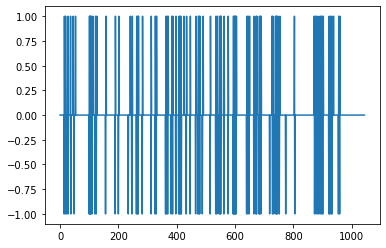

In [63]:
plt.plot(aBeepMask-np.roll(aBeepMask,-1))

In [37]:
np.where(vSum>98)

(array([ 10343,  10344,  10345,  10346,  10347,  10348,  50200,  50201,
         50202,  50203,  50204,  50205,  50206,  50207,  50208,  50209,
         50210,  50211, 122297, 122298, 122299, 122300, 122301, 122302,
        122303, 122304, 122305, 122306, 122307, 122308, 221751, 221752,
        221753, 221754, 221755, 221756, 221757, 221758, 221759, 268288,
        268289, 268290, 268291, 268292, 268293, 268294, 268295, 268296,
        268297, 268298, 268299, 268300]),)

In [82]:
dBeepTimes[testFileName]

[(30.66, 31.66),
 (552.8480000000001, 553.8480000000001),
 (1334.75, 1335.75),
 (2225.89, 2226.89),
 (2248.935, 2249.935),
 (2744.7090000000003, 2745.7090000000003),
 (3403.236, 3404.236)]

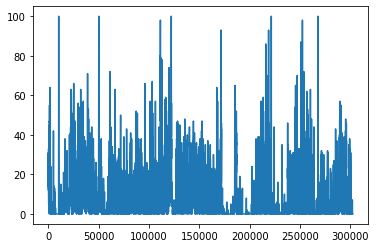

In [16]:
plt.plot(vSum)

In [90]:
aBeepMask.shape
vSum.shape

(370660,)

In [4]:
f = wave.open('egs/Beeps/Sample1.wav')

In [6]:
f.getnframes()

1343414

In [7]:
d = f.readframes(10)

In [8]:
f.tell()

10

In [9]:
d

b'N\x00I\x00H\x00<\x00>\x002\x004\x004\x00/\x001\x00'

In [23]:
data = [i[0] for i in struct.iter_unpack('h',d)]

In [24]:
data

[78, 73, 72, 60, 62, 50, 52, 52, 47, 49]

In [12]:
f.setpos(5)

In [13]:
f.tell()

5

In [58]:
import numpy

In [17]:
data_beep.shape

(2437, 34)

In [19]:
data_beep = data_beep[:,:34]

In [38]:
pdData.to_pickle('Beep_NonBeep.gzip',compression='gzip')

In [29]:
pdData = pdData.rename(columns={'lable':'label'})

In [37]:
pdData

,zcr,energy,energy_entropy,spectral_centroid,spectral_spread,spectral_entropy,spectral_flux,spectral_rolloff,mfcc_1,mfcc_2,...,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,chroma_11,chroma_12,chroma_std,label
0,0.026107,0.023881,2.952514,0.149147,0.239787,0.127924,0.000000,0.022676,-24.828048,2.665265,...,0.022029,0.021238,0.000235,0.000314,0.008918,0.001560,0.198840,0.000447,0.053615,1
1,0.039728,0.010181,2.792336,0.125940,0.235431,0.074945,0.009646,0.022676,-26.299752,3.146192,...,0.018564,0.011332,0.000123,0.000949,0.004107,0.000762,0.146623,0.000438,0.039614,1
2,0.057889,0.018654,1.944444,0.340922,0.255146,1.439361,0.020274,0.562358,-25.740006,2.078188,...,0.004672,0.028268,0.000302,0.002667,0.008031,0.001571,0.071698,0.000468,0.020861,1
3,0.150965,0.034977,2.674830,0.346859,0.256991,1.176551,0.004105,0.546485,-25.984883,2.449404,...,0.000302,0.022524,0.000113,0.000931,0.001405,0.001999,0.153657,0.000235,0.042105,1
4,0.357548,0.034518,3.145192,0.313703,0.266910,1.087860,0.008439,0.544218,-26.793118,2.463520,...,0.001661,0.010340,0.000085,0.000150,0.002542,0.001178,0.132129,0.000050,0.035941,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44030,0.011351,0.149749,2.540470,0.134250,0.241330,0.050390,0.028181,0.009070,-23.830157,2.753325,...,0.000216,0.005289,0.000099,0.000412,0.001147,0.000189,0.241018,0.000177,0.066119,0
44031,0.015891,0.069312,2.959871,0.137631,0.261177,0.035866,0.006084,0.009070,-25.840094,3.149468,...,0.000834,0.013769,0.000023,0.000090,0.002541,0.000063,0.219121,0.000074,0.060025,0
44032,0.017026,0.179122,2.612994,0.114428,0.233535,0.022877,0.010135,0.009070,-24.292798,3.310984,...,0.000163,0.012701,0.000034,0.000190,0.001060,0.000047,0.252514,0.000056,0.069179,0
44033,0.017026,0.180206,2.685020,0.111079,0.237368,0.018542,0.012567,0.009070,-25.440577,3.170213,...,0.000059,0.039243,0.000014,0.000083,0.000050,0.000163,0.209545,0.000077,0.057598,0


In [47]:
sklearn.__version__

'0.22.1'

In [24]:
fWav.getsampwidth()

3

In [25]:
import scipy

In [26]:
fr, data = scipy.io.wavfile.read('egs/Beeps/Sample1.wav')

AttributeError: module 'scipy' has no attribute 'io'

In [27]:
scipy.__version__

'1.4.1'

In [31]:
dBeepTimes

defaultdict(list,
            {'/media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Primary_07-01.wav': [(13.1,
               14.1)],
             '/media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mostafa_kids/Primary_04-01.wav': [(34.91,
               35.91),
              (194.435, 195.435),
              (332.31800000000004, 333.31800000000004),
              (1050.538, 1051.538),
              (1065.531, 1066.531),
              (1268.032, 1269.032),
              (1357.734, 1358.734),
              (1392.733, 1393.8329999999999),
              (1422.634, 1423.634)],
             '/media/Windows/root/AusKidTalk/Recordings/10_March_2020/Audio 1_01-01.wav': [(7.21,
               8.21),
              (279.3, 280.3),
              (380.62, 381.62)],
             '/media/Windows/root/AusKidTalk/Recordings/24_jan_2020/child_2_2/Primary_03-01.wav': [(462.639,
               463.639),
              (598.61, 599.61)],
             '/media/Windows/root/AusKidTalk/Recordi

In [10]:
2680.18 % 60

40.179999999999836

In [11]:
2680.18/60

44.669666666666664

In [47]:
a = np.arange(1,41)

In [48]:
a = a.reshape(10,4)

In [49]:
a

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [17, 18, 19, 20],
       [21, 22, 23, 24],
       [25, 26, 27, 28],
       [29, 30, 31, 32],
       [33, 34, 35, 36],
       [37, 38, 39, 40]])

In [26]:
a[0]

array([1, 2, 3, 4])

In [29]:
np.r_[a[0],a[1],a[2]]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [31]:
i=2

In [32]:
c = (-1,0,1)

In [37]:
np.roll(a,-1,axis=0)

array([[ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [17, 18, 19, 20],
       [21, 22, 23, 24],
       [25, 26, 27, 28],
       [29, 30, 31, 32],
       [33, 34, 35, 36],
       [37, 38, 39, 40],
       [ 1,  2,  3,  4]])

In [45]:
np.c_[np.roll(a,1,axis=0),np.roll(a,0,axis=0),np.roll(a,-1,axis=0)]

array([[37., 38., 39., 40.,  0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.],
       [ 0.,  0.,  0.,  0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.],
       [ 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.],
       [13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.],
       [17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.],
       [21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.],
       [25., 26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36.],
       [29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.],
       [33., 34., 35., 36., 37., 38., 39., 40.,  0.,  0.,  0.,  0.]])

In [43]:
a = np.r_[np.zeros((1,a.shape[1])),a]

In [56]:
a

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [17, 18, 19, 20],
       [21, 22, 23, 24],
       [25, 26, 27, 28],
       [29, 30, 31, 32],
       [33, 34, 35, 36],
       [37, 38, 39, 40]])

In [117]:
c = (-2,-1,0,1,2)

In [118]:
max(c)

2

In [119]:
min(c)

-2

In [120]:
nPostPad = max(c)
nPrePad = abs(min(c))

In [121]:
aPostPad = np.zeros((nPostPad,a.shape[1]))
aPrePad = np.zeros((nPrePad,a.shape[1]))

In [122]:
aPostPad.shape

(2, 4)

In [123]:
a_pad = np.r_[aPrePad,a,aPostPad]

In [124]:
a_pad.shape

(14, 4)

In [125]:
xx = [np.roll(a_pad,i,axis=0) for i in c[::-1]]

In [126]:
np.concatenate(xx,axis=1)[0+nPrePad:-nPostPad].shape

(10, 20)

In [7]:
list(dBeepTimes.keys())

['/media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Primary_07-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Testing_with_Mostafa_kids/Primary_04-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/10_March_2020/Audio 1_01-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/24_jan_2020/child_2_2/Primary_03-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/24_jan_2020/Child1/Primary_01-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/24_jan_2020/Child2/Primary_02-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/28_jul_2020/81 3_2_0/81 Primary_13-01.wav',
 '/media/Windows/root/AusKidTalk/Recordings/13_aug_2020/90 3_2_0/90 Primary_15-01.wav',
 0]

In [1]:
f = '/media/Windows/root/AusKidTalk/Recordings/28_jul_2020/81 3_2_0/81 Primary_13-01.wav'

In [14]:
z = np.load('egs/BeepDetModel/egs/egs_5_1.npy')

In [15]:
z.shape

(18982, 172)

In [19]:
np.where(z[:,-1]==0)[0].shape

(18081,)

In [24]:
xx = [np.load('egs/BeepDetModel/egs/egs_{0}.npy'.format(i)) for i in range(8)]

In [25]:
xx

[array([[0.        , 0.        , 0.        , ..., 0.03961403, 0.        ,
         1.        ],
        [0.0261067 , 0.023881  , 2.95251418, ..., 0.02086051, 0.        ,
         1.        ],
        [0.03972758, 0.01018135, 2.79233571, ..., 0.04210504, 0.        ,
         1.        ],
        ...,
        [0.03632236, 0.08585858, 3.16158758, ..., 0.02501251, 0.        ,
         0.        ],
        [0.05561862, 0.06888916, 3.11556522, ..., 0.03855069, 0.        ,
         0.        ],
        [0.05107832, 0.0576163 , 3.19697933, ..., 0.        , 0.        ,
         0.        ]]),
 array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         2.34946135e-03, 1.00000000e+00, 1.00000000e+00],
        [5.44835414e-01, 2.68381203e-01, 3.28015702e+00, ...,
         1.64341840e-03, 1.00000000e+00, 1.00000000e+00],
        [5.44835414e-01, 3.43247403e-01, 3.31031953e+00, ...,
         1.86870431e-03, 1.00000000e+00, 1.00000000e+00],
        ...,
        [3.17820658e-02, 8.00373653e

In [26]:
c = np.concatenate(xx,axis=0)

In [27]:
c.shape

(51348, 104)

In [31]:
c[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  2.61066969e-02,  2.38809978e-02,
        2.95251418e+00,  1.49146586e-01,  2.39787433e-01,  1.27923699e-01,
        0.00000000e+00,  2.26757370e-02, -2.48280482e+01,  2.66526479e+00,
        1.05931726e-01,  1.07515522e-01,  1.66281890e-01,  2.73602186e-01,
        2.19841888e-01,  1.37654325e-01, -9.98709153e-02, -4.28346715e-02,
       -1.32253766e-01, -

In [32]:
c.shape

(51348, 104)

In [33]:
c[:,2*nFeatures:3*nFeatures].shape

(51348, 34)

In [38]:
mask = np.zeros(c.shape,dtype=bool)

In [62]:
data_NoContxt.shape

(149740, 36)

In [63]:
lFeatures_names

['zcr',
 'energy',
 'energy_entropy',
 'spectral_centroid',
 'spectral_spread',
 'spectral_entropy',
 'spectral_flux',
 'spectral_rolloff',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12',
 'mfcc_13',
 'chroma_1',
 'chroma_2',
 'chroma_3',
 'chroma_4',
 'chroma_5',
 'chroma_6',
 'chroma_7',
 'chroma_8',
 'chroma_9',
 'chroma_10',
 'chroma_11',
 'chroma_12',
 'chroma_std']

In [65]:
len(lFeatures_names+['f','g'])

36

In [18]:
pp = [1,2,3,2,1]

In [19]:
import scipy

In [41]:
scipy.signal.find_peaks(vSum,height=98)[0]

array([ 10345,  50205, 122302, 221755, 268294])

In [44]:
lFileNames[7]

'/media/Windows/root/AusKidTalk/Recordings/13_aug_2020/90 3_2_0/90 Primary_15-01.wav'

In [ ]:
#Load egs Data
legs = glob.glob(os.path.join(egs_dir,'*.npy'))
assert len(legs) > 0, 'No egs'

#Load data from egs directory
data = np.concatenate([np.load(file) for file in legs],axis=0)
X = data[:,:-2]
y = data[:,-1].astype(int)
groups = data[:,-2].astype(int)

#Split data where one recording out
spliter = LeaveOneGroupOut()
print(spliter.get_n_splits(X,y,groups))
print(X.shape,y.shape)

#Load CSV file in dictionary of key=filename, value=[(start_beep_time,end_beep_time),]
dBeepTimes = defaultdict(list)
sBeepTimesCSVFile = '../../Recordings/Beep_Times.csv'
Beep_Times = pd.read_csv(sBeepTimesCSVFile,header=None)
for index, row in Beep_Times.iterrows():
    sWavFile = row[0]
    i = 1
    while i <= row.size-1:
        #print(i)
        if not np.isnan(row[i]):
            dBeepTimes[sWavFile].append((row[i],row[i+1]))
            i += 2
        else:
            i += 1
lFileNames = list(dBeepTimes.keys())


TestFileIndex = 0
for train_indx, test_indx in spliter.split(X,y,groups):
    testFileName = lFileNames[TestFileIndex]
    print('File {0} ********************'.format(testFileName))
    
    X_train, X_test, y_train, y_test = X[train_indx], X[test_indx], y[train_indx], y[test_indx]
    TestFileIndex += 1
    
    print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    clf = Pipeline([('scaler',StandardScaler()),('svc',svm.SVC(kernel='rbf', C=10, gamma=0.0001, class_weight='balanced'))])
    clf.fit(X_train, y_train)


8
(149740, 170) (149740,)
File /media/Windows/root/AusKidTalk/Recordings/9_jan_2020/Primary_07-01.wav ********************
(131266, 170) (18474, 170) (131266,) (18474,)


In [3]:
c = np.zeros(30)

In [4]:
c[0:20] = 1

In [5]:
c

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [1]:
import configparser

In [2]:
config = configparser.ConfigParser()

In [3]:
conf = config.read('beep.ini')

In [4]:
conf

['beep.ini']

In [5]:
try:
    flags = config['FLAGS']
except KeyError:
    print('Config file should contain [FLAGS] section')
print('Hi')

Hi


In [7]:
Flags = flags
if 'Context' in Flags:
    Context = tuple([int(i) for i in Flags['Context'].split(',')])
if 'FrameRate' in Flags:
    fFrameRate = Flags.getfloat('FrameRate')
if 'WindowSize' in Flags:
    fWindowSize = Flags.getfloat('WindowSize')
if 'UseDelta' in Flags:
    bUseDelta = Flags.getboolean('UseDelta')
if 'FeatureType' in Flags:
    sFeatureType = Flags['FeatureType']

In [12]:
sFeatureType

'STF'

In [65]:
lPeaks*0.01

array([ 103.45,  502.05, 1223.02, 2217.55, 2682.94])

In [66]:
'Context' in flags

True

In [67]:
Context = tuple([int(i) for i in flags['Context'].split(',')])

In [68]:
Context

(-2, -1, 0, 1, 2)

In [69]:
flags.getboolean('UseDelta')

False

In [70]:
import cProfile

In [72]:
cProfile.run("config.read('beep.ini')")

         154 function calls in 0.000 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.000    0.000 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _bootlocale.py:33(getpreferredencoding)
        1    0.000    0.000    0.000    0.000 abc.py:137(__instancecheck__)
        1    0.000    0.000    0.000    0.000 codecs.py:260(__init__)
        1    0.000    0.000    0.000    0.000 codecs.py:309(__init__)
        2    0.000    0.000    0.000    0.000 codecs.py:319(decode)
        7    0.000    0.000    0.000    0.000 configparser.py:1017(<dictcomp>)
        1    0.000    0.000    0.000    0.000 configparser.py:1112(_join_multiline_values)
        6    0.000    0.000    0.000    0.000 configparser.py:368(before_read)
        1    0.000    0.000    0.000    0.000 configparser.py:678(read)
        6    0.000    0.000    0.000    0.000 configparser.py:872(optionxform)
        1    0.

In [79]:
lFeatures_names[:20]

['zcr',
 'energy',
 'energy_entropy',
 'spectral_centroid',
 'spectral_spread',
 'spectral_entropy',
 'spectral_flux',
 'spectral_rolloff',
 'mfcc_1',
 'mfcc_2',
 'mfcc_3',
 'mfcc_4',
 'mfcc_5',
 'mfcc_6',
 'mfcc_7',
 'mfcc_8',
 'mfcc_9',
 'mfcc_10',
 'mfcc_11',
 'mfcc_12']